In [97]:
import pandas as pd
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

In [7]:
df = pd.read_csv('../nss_capstone/df_rebuild.csv').drop(columns = 'Unnamed: 0').fillna('')

In [8]:
df = df.apply(pd.to_numeric, errors='coerce')

In [9]:
df.columns

Index(['game_id', 'Date', 'VH', 'Team', 'Final', 'ML', 'ML_pct', 'Open Total',
       'Close Total', 'Open Spread', 'Close Spread', 'W/L_fav', 'W/L_dog',
       'ATS_fav', 'W/L_H_fav', 'W/L_V_fav', 'W/L_H_dog', 'W/L_V_dog',
       'ATS_H_fav', 'ATS_V_fav', 'ATS_H_dog', 'ATS_V_dog', 'Push', 'W/L_bool'],
      dtype='object')

                                    ***********Random Forest******************

In [20]:
df = pd.read_csv('../nss_capstone/df_rebuild.csv')

variables = ['ML_pct',
             #'Open Total',
            #'Open Spread',
            'Close Total',
             'Close Spread']

X = df[variables]
y = df['W/L_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_classifier = RandomForestClassifier()

calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5) # isotonic/ cv?

calibrated_classifier.fit(X_train_imputed, y_train)

probabilities = calibrated_classifier.predict_proba(X_test_imputed)

In [21]:
df_prob = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [22]:
df_prob

,Class 0 Probability,Class 1 Probability
0,0.507936,0.492064
1,0.554206,0.445794
2,0.757404,0.242596
3,0.217305,0.782695
4,0.733971,0.266029
...,...,...
7190,0.680116,0.319884
7191,0.785159,0.214841
7192,0.426466,0.573534
7193,0.673829,0.326171


In [110]:
df_val = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

X_val_imputed = imputer.transform(df_val[variables])

probabilities = calibrated_classifier.predict_proba(X_val_imputed)

In [111]:
df_prob_val = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [25]:
df_prob_val.head(13)

,Class 0 Probability,Class 1 Probability
0,0.433040,0.566960
1,0.353089,0.646911
2,0.480878,0.519122
3,0.770147,0.229853
4,0.369859,0.630141
5,0.615520,0.384480
6,0.472446,0.527554
7,0.701995,0.298005
8,0.504774,0.495226
9,0.577688,0.422312


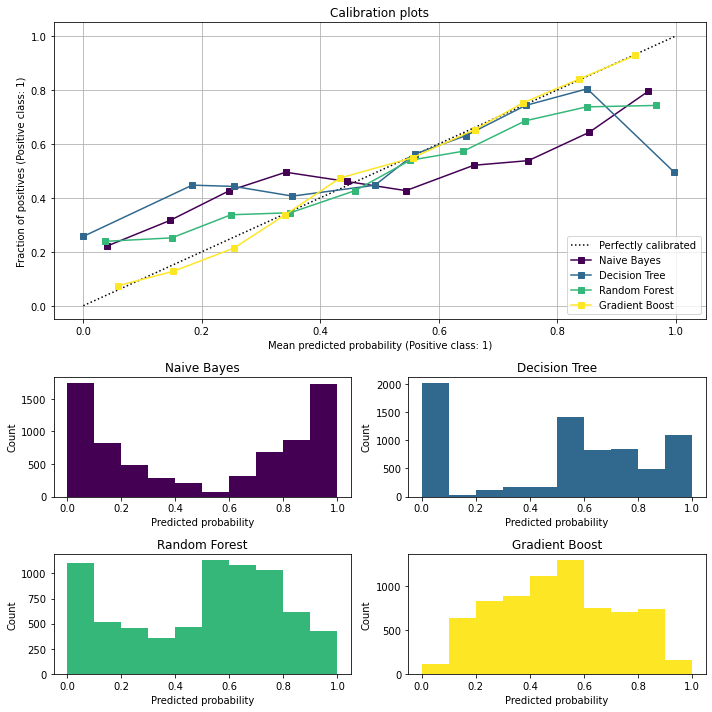

In [108]:
imputer = SimpleImputer(strategy='mean')

# Apply imputation on your training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

dt = DecisionTreeClassifier()
nb = GaussianNB()
rf = RandomForestClassifier()
grb = GradientBoostingClassifier()


# rf_isotonic = CalibratedClassifierCV(rf, cv=2, method='isotonic')
# rf_sigmoid = CalibratedClassifierCV(rf, cv=2, method='sigmoid')
# grb_isotonic = CalibratedClassifierCV(grb, cv=2, method='isotonic')
# grb_sigmoid = CalibratedClassifierCV(grb, cv=2, method='sigmoid')


clf_list = [
    (nb, 'Naive Bayes'),
    (dt, 'Decision Tree'),
    (rf, 'Random Forest'),
    (grb, 'Gradient Boost')
    #(rf_isotonic, 'Random Forest + Isotonic'),
    #(rf_sigmoid, 'Random Forest + Sigmoid'),
    #(grb_isotonic, 'Gradient Boost + Isotonic')
    #(grb_sigmoid, 'Gradient Boost + Sigmoid')
]

#court_image = mpimg.imread("path/to/basketball_court_image.jpg")

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("viridis", len(clf_list))

# ax_court = fig.add_subplot(gs[:, :])

# ax_court.imshow(court_image, aspect='auto', extent=[0, 1, 0, 1])


ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train_imputed, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_imputed,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plots')

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (3, 1), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

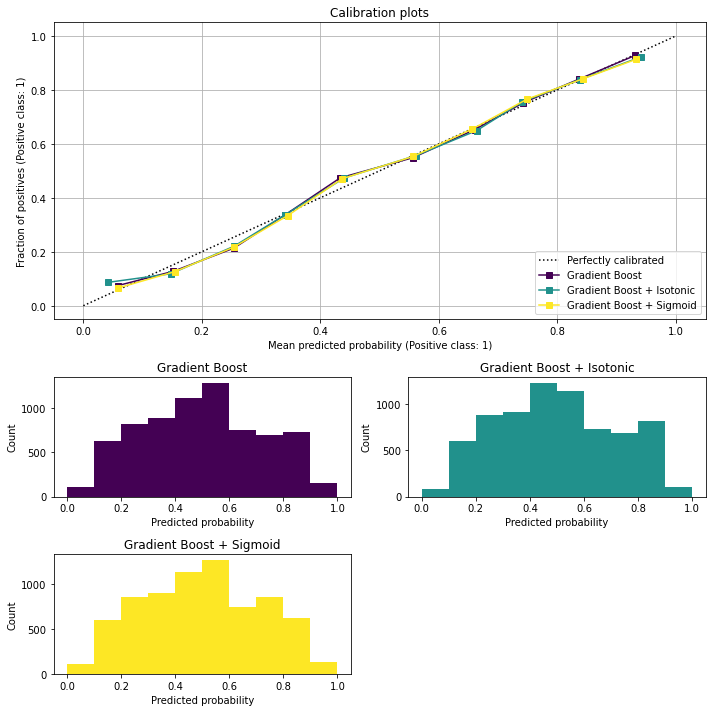

In [109]:
imputer = SimpleImputer(strategy='mean')

# Apply imputation on your training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

dt = DecisionTreeClassifier()
nb = GaussianNB()
rf = RandomForestClassifier()
grb = GradientBoostingClassifier()


# rf_isotonic = CalibratedClassifierCV(rf, cv=2, method='isotonic')
# rf_sigmoid = CalibratedClassifierCV(rf, cv=2, method='sigmoid')
# grb_isotonic = CalibratedClassifierCV(grb, cv=2, method='isotonic')
# grb_sigmoid = CalibratedClassifierCV(grb, cv=2, method='sigmoid')


clf_list = [
    #(nb, 'Naive Bayes'),
    #(dt, 'Decision Tree'),
    #(rf, 'Random Forest'),
    (grb, 'Gradient Boost'),
    #(rf_isotonic, 'Random Forest + Isotonic'),
    #(rf_sigmoid, 'Random Forest + Sigmoid'),
    (grb_isotonic, 'Gradient Boost + Isotonic'),
    (grb_sigmoid, 'Gradient Boost + Sigmoid')
]

#court_image = mpimg.imread("path/to/basketball_court_image.jpg")

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("viridis", len(clf_list))

# ax_court = fig.add_subplot(gs[:, :])

# ax_court.imshow(court_image, aspect='auto', extent=[0, 1, 0, 1])


ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train_imputed, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_imputed,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plots')

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (3, 1), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [82]:
#df.loc[df['game_id'] == 17985]

In [81]:
wager = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

In [82]:
wager[[ 'game_id', 'Team','ML','ML_pct', 'W/L_bool']].head(16)

,game_id,Team,ML,ML_pct,W/L_bool
0,1,Boston,-155,60.784314,1
1,1,Philadelphia,155,39.215686,0
2,2,GoldenState,-310,75.609756,1
3,2,LALakers,310,24.390244,0
4,3,Washington,-135,57.446809,1
5,3,Indiana,135,42.553191,0
6,4,Detroit,-175,63.636364,1
7,4,Orlando,175,36.363636,0
8,5,Memphis,-185,64.912281,1
9,5,NewYork,185,35.087719,0


                                ***************Gradient Boost************************

In [ ]:
#df = pd.read_csv('../nss_capstone/df_rebuild.csv').drop(columns = 'Unnamed: 0').fillna('')

In [24]:
df = df.apply(pd.to_numeric, errors='coerce')

In [28]:
variables = ['ML_pct',
#             'Open Total',
#             'Open Spread',
            'Close Total',
            'Close Spread']

X = df[variables]
y = df['W/L_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_classifier = GradientBoostingClassifier()

calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5)

calibrated_classifier.fit(X_train_imputed, y_train)

probabilities = calibrated_classifier.predict_proba(X_test_imputed)

In [29]:
df_prob = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [30]:
df_prob

,Class 0 Probability,Class 1 Probability
0,0.585932,0.414068
1,0.739284,0.260716
2,0.772641,0.227359
3,0.119857,0.880143
4,0.868415,0.131585
...,...,...
7190,0.650938,0.349062
7191,0.682925,0.317075
7192,0.586458,0.413542
7193,0.804976,0.195024


In [31]:
df_val = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

X_val_imputed = imputer.transform(df_val[variables])

probabilities = calibrated_classifier.predict_proba(X_val_imputed)

In [32]:
df_prob_val = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [33]:
df_prob_val.head(13)

,Class 0 Probability,Class 1 Probability
0,0.367910,0.632090
1,0.572923,0.427077
2,0.399133,0.600867
3,0.771944,0.228056
4,0.287318,0.712682
5,0.560134,0.439866
6,0.424516,0.575484
7,0.643706,0.356294
8,0.398210,0.601790
9,0.672634,0.327366


In [71]:
wager = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

In [78]:
wager[[ 'game_id', 'Team','ML','ML_pct', 'W/L_bool']].head(16)

,game_id,Team,ML,ML_pct,W/L_bool
0,1,Boston,-155,60.78,1
1,1,Philadelphia,155,39.22,0
2,2,GoldenState,-310,75.61,1
3,2,LALakers,310,24.39,0
4,3,Washington,-135,57.45,1
5,3,Indiana,135,42.55,0
6,4,Detroit,-175,63.64,1
7,4,Orlando,175,36.36,0
8,5,Memphis,-185,64.91,1
9,5,NewYork,185,35.09,0


                        *************DECISION TREE*******************

In [44]:
variables = ['ML_pct',
#             'Open Total',
#             'Open Spread',
            'Close Total',
            'Close Spread']

X = df[variables]
y = df['W/L_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_classifier = DecisionTreeClassifier()

calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5)

calibrated_classifier.fit(X_train_imputed, y_train)

probabilities = calibrated_classifier.predict_proba(X_test_imputed)

In [45]:
df_prob = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [46]:
df_prob

,Class 0 Probability,Class 1 Probability
0,0.504574,0.495426
1,0.509524,0.490476
2,0.685328,0.314672
3,0.389051,0.610949
4,0.685328,0.314672
...,...,...
7190,0.571139,0.428861
7191,0.685328,0.314672
7192,0.386134,0.613866
7193,0.537799,0.462201


In [47]:
df_val = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

X_val_imputed = imputer.transform(df_val[variables])

probabilities = calibrated_classifier.predict_proba(X_val_imputed)

In [48]:
df_prob_val = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [49]:
df_prob_val

,Class 0 Probability,Class 1 Probability
0,0.449407,0.550593
1,0.457268,0.542732
2,0.542112,0.457888
3,0.612385,0.387615
4,0.380896,0.619104
...,...,...
1323,0.469582,0.530418
1324,0.509500,0.490500
1325,0.685328,0.314672
1326,0.606606,0.393394


In [73]:
wager = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

In [79]:
wager[[ 'game_id', 'Team','ML','ML_pct', 'W/L_bool']].head(16)

,game_id,Team,ML,ML_pct,W/L_bool
0,1,Boston,-155,60.78,1
1,1,Philadelphia,155,39.22,0
2,2,GoldenState,-310,75.61,1
3,2,LALakers,310,24.39,0
4,3,Washington,-135,57.45,1
5,3,Indiana,135,42.55,0
6,4,Detroit,-175,63.64,1
7,4,Orlando,175,36.36,0
8,5,Memphis,-185,64.91,1
9,5,NewYork,185,35.09,0


                        *******************NAIVE BAYES***********************

In [36]:

variables = ['ML_pct',
#             'Open Total',
#             'Open Spread',
            'Close Total',
            'Close Spread']

X = df[variables]
y = df['W/L_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_classifier = GaussianNB()

calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5)

calibrated_classifier.fit(X_train_imputed, y_train)

probabilities = calibrated_classifier.predict_proba(X_test_imputed)

In [37]:
df_prob = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [38]:
df_prob

,Class 0 Probability,Class 1 Probability
0,0.688711,0.311289
1,0.763661,0.236339
2,0.729117,0.270883
3,0.244127,0.755873
4,0.764080,0.235920
...,...,...
7190,0.690116,0.309884
7191,0.699117,0.300883
7192,0.753524,0.246476
7193,0.745158,0.254842


In [39]:
df_val = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

X_val_imputed = imputer.transform(df_val[variables])

probabilities = calibrated_classifier.predict_proba(X_val_imputed)

In [40]:
df_prob_val = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [41]:
df_prob_val

,Class 0 Probability,Class 1 Probability
0,0.771188,0.228812
1,0.656538,0.343462
2,0.771188,0.228812
3,0.758739,0.241261
4,0.771188,0.228812
...,...,...
1323,0.764189,0.235811
1324,0.771188,0.228812
1325,0.770463,0.229537
1326,0.771188,0.228812


In [75]:
wager = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

In [80]:
wager[[ 'game_id', 'Team','ML','ML_pct', 'W/L_bool']].head(16)

,game_id,Team,ML,ML_pct,W/L_bool
0,1,Boston,-155,60.78,1
1,1,Philadelphia,155,39.22,0
2,2,GoldenState,-310,75.61,1
3,2,LALakers,310,24.39,0
4,3,Washington,-135,57.45,1
5,3,Indiana,135,42.55,0
6,4,Detroit,-175,63.64,1
7,4,Orlando,175,36.36,0
8,5,Memphis,-185,64.91,1
9,5,NewYork,185,35.09,0
